In [2]:
import os
# Set environment variables to help manage CUDA memory
os.environ['CUDA_VISIBLE_DEVICES'] = "MIG-b5356651-0d8e-5cd1-bdf3-ccbb8b221031"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [2]:
import re
import glob
import yaml
import warnings
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
pl.seed_everything(42)

from dataset import E33OMA
from model import STMLightning
from utils import qqplot, find_nearest

import geopandas as gpd
from cartopy import crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Load the world shapefile provided by geopandas
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

Seed set to 42
/home/serfani/miniforge3/envs/Lightning/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def natural_sort_key(s):
    # Split the string into segments of digits and non-digits
    return [int(text) if text.isdigit() else text.lower() for text in re.split('(\d+)', s)]

models_path_root = '/home/serfani/serfani_data1/snapshots'
# List directory contents
dir_contents = os.listdir(models_path_root)

# Sort using the custom sort key
sorted_contents = sorted(dir_contents, key=natural_sort_key)

# Print sorted contents
for idx, model in enumerate(sorted_contents):
    print(idx, model)

0 Conv3D-03122025-1601
1 Conv3D-03122025-1651
2 Conv3D-03142025-1002
3 Conv3D-03192025-1113
4 ConvLSTM-02102025-1714
5 ConvLSTM-03122025-1209
6 ConvLSTM-03122025-1308
7 ConvLSTM-03242025-1200
8 ConvLSTM-04152025-1359
9 LSTM-64K5.32K3.16K3-E33OMA90D-5C-BCB-20241014-1247
10 LSTM-64K5.32K3.16K3-E33OMA-5C-BCB-20240723-0949
11 LSTM-64K5.32K3.16K3-E33OMA-8C-BCB-20240719-1241
12 SimVP-02132025-1532
13 UNet-E33OMA-5C-BCB-20240718-1527


In [4]:
model_index = 8
model_name  = sorted_contents[model_index]

save_figure = False

# Read the YAML/CKPT files
snapshot_dir = os.path.join(models_path_root, model_name)
config_filepath = glob.glob(os.path.join(snapshot_dir, "version_*", "hparams.yaml"))[0]
checkpoint_path = glob.glob(os.path.join(snapshot_dir, "version_*", "checkpoints", "*.ckpt"))[0]

with open(config_filepath, 'r') as config_file:
    hyperparams = yaml.load(config_file, Loader=yaml.FullLoader)

model_args = hyperparams['model_args']
data_args = hyperparams['data_args']

# Print dynamically created variables
for cat in ['model_args', 'data_args']:
    print(f'{cat}:')
    for key, value in hyperparams[cat].items():
        print(f'{key}: {value}')
    print()

model_args:
encoder_channels: [64, 64, 64]
epochs: 50
in_channels: 64
kernel_size: [3, 3, 3]
learning_rate: 0.001
log_dir: /home/serfani/serfani_data1/snapshots
loss: ['MSE', 'MAE']
model_name: ConvLSTM
optimizer: Adam
out_channels: 5
scheduler: StepLR
scheduler_params: {'gamma': 0.5, 'step_size': 10}
weight_decay: 0.0

data_args:
batch_size: 4
data_name: E33OMA
levels: 5
num_workers: 4
padding: [5, 5]
sequence_length: 48
size: [90, 144]
species: bcb



In [7]:
for root, dirs, files in os.walk('/home/serfani/serfani_data1/E3OMA1850'):
    
    sorted_files = sorted(files)
    list5 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'tNDaijh1E3oma']  # Clay_emission, BCB_biomass_src, OCB_biomass_src (time, lat, lon)

ds5  = xr.open_mfdataset(list5[-219:])

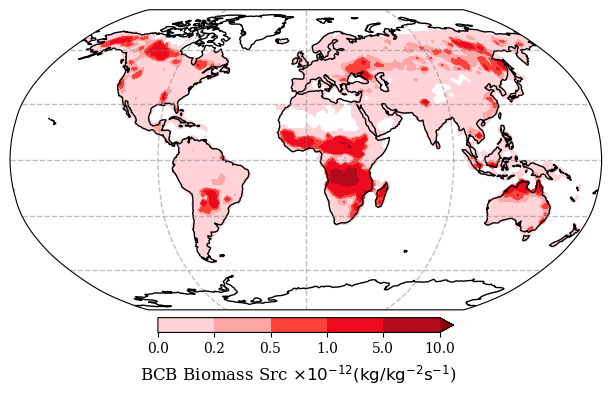

In [12]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds5['lon'], ds5['lat'])

data = ds5['BCB_biomass_src'].mean(dim='time')
data = np.where(data <= 0.0, np.nan, data)
ax.coastlines()

colors = [(0.0, 'mistyrose'), (0.025, 'pink'), (0.05, 'salmon'), (0.1, 'red'), (0.5, 'crimson'), (1.0, 'darkred')]
cmap = mcolors.LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

im = ax.contourf(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    levels=[0, 0.25, 0.5, 1.0, 5.0, 10], 
    cmap=cmap, extend='max'
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])


# Add an individual colorbar for each subplot
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.5)
cbar.set_label(r'BCB Biomass Src $ \times 10^{-12} (\mathrm{kg} / \mathrm{kg}^{-2} \mathrm{s}^{-1}$)', rotation=0, labelpad=5, fontsize=12)
cbar.ax.tick_params(labelsize=10)  # Adjust the font size here
cbar.ax.xaxis.set_major_formatter(mticker.FormatStrFormatter('%.1f'))


if save_figure:
    plt.savefig(os.path.join(snapshot_dir, '00-source.png'))

plt.show()

### Load Dataset and Model

In [5]:
dataset = E33OMA(period='test', species=data_args['species'], padding=data_args['padding'], levels=data_args['levels'], sequence_length=data_args['sequence_length'])
dataloader = DataLoader(dataset, batch_size=4, shuffle=False , num_workers=4, pin_memory=True, persistent_workers=True)

In [8]:
net = STMLightning.load_from_checkpoint(
    checkpoint_path=checkpoint_path,
    model_args=model_args,
    data_args=data_args
)
net.eval()

STMLightning(
  (model): Model(
    (encoder): FMEncoder(
      (enc1): Encoder(
        (conv0): Conv2d(7, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv1): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (norm): GroupNorm(4, 64, eps=1e-05, affine=True)
          (act): SiLU(inplace=True)
        )
        (conv2): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (norm): GroupNorm(4, 64, eps=1e-05, affine=True)
          (act): SiLU(inplace=True)
        )
      )
      (enc2): Encoder(
        (conv0): Conv2d(50, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv1): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
          (norm): GroupNorm(4, 64, eps=1e-05, affine=True)
          (act): SiLU(inplace=True)
        )
        (conv2): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=

In [15]:
# Preallocation
total_samples = len(dataloader.dataset)
GTs = torch.empty((total_samples, 1, 1, data_args['levels'], data_args['size'][0], data_args['size'][1]), dtype=torch.float32)
PDs = torch.empty((total_samples, 1, 1, data_args['levels'], data_args['size'][0], data_args['size'][1]), dtype=torch.float32)

y_avg = torch.tensor(dataset.y_mean, dtype=torch.float32).cuda()
y_std = torch.tensor(dataset.y_std, dtype=torch.float32).cuda()


sample_index = 0
with torch.no_grad():
    for counter, (X2D, X3D, y) in enumerate(dataloader, 1):

        batch_size = X2D.shape[0]

        X2D = X2D.cuda(non_blocking=True)      
        X3D = X3D.cuda(non_blocking=True)      
        y = y.cuda(non_blocking=True)

        p = net(X2D, X3D)
        p = p[..., 
                  data_args['padding'][0]:data_args['padding'][0]+data_args['size'][0], 
                  data_args['padding'][1]:data_args['padding'][1]+data_args['size'][1]]

        GTs[sample_index:sample_index+batch_size] = (y * y_std) + y_avg
        PDs[sample_index:sample_index+batch_size] = (p * y_std) + y_avg
        
        sample_index += batch_size

GTs = GTs.cpu().numpy()
PDs = PDs.cpu().numpy()

print(GTs.shape, PDs.shape)

(10512, 1, 1, 5, 90, 144) (10512, 1, 1, 5, 90, 144)


In [16]:
with open(os.path.join(snapshot_dir, 'test-results.npy'), mode = 'wb') as f:

    np.save(f, GTs)
    np.save(f, PDs)

In [6]:
with open(os.path.join(snapshot_dir, 'test-results.npy'), mode='rb') as f:
    
    GTs = np.load(f, allow_pickle=True)
    PDs = np.load(f, allow_pickle=True)

print(GTs.shape, PDs.shape)

(10512, 1, 1, 5, 90, 144) (10512, 1, 1, 5, 90, 144)


In [7]:
for root, dirs, files in os.walk('/home/serfani/serfani_data1/E3OMA1850'):
    
    sorted_files = sorted(files)
    list2 = [os.path.join(root, file) for file in sorted_files if file.split(".")[1] == 'aijlh1E3oma']    # Forcings (time, level, lat, lon)

ds2 = xr.open_mfdataset(list2[-219:])
ds2

<xarray.Dataset> Size: 271GB
Dimensions:  (time: 10512, lat: 90, lon: 144, level: 62)
Coordinates:
  * lon      (lon) float32 576B -178.8 -176.2 -173.8 ... 173.8 176.2 178.8
  * lat      (lat) float32 360B -90.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 90.0
  * level    (level) float32 248B 1.0 2.0 3.0 4.0 5.0 ... 59.0 60.0 61.0 62.0
  * time     (time) object 84kB 1853-05-27 00:15:00 ... 1853-12-31 23:45:00
Data variables:
    axyp     (time, lat, lon) float32 545MB dask.array<chunksize=(48, 90, 144), meta=np.ndarray>
    u        (time, level, lat, lon) float32 34GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    v        (time, level, lat, lon) float32 34GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    omega    (time, level, lat, lon) float32 34GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    p_3d     (time, level, lat, lon) float32 34GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    z        (time, level, lat, lon) float32 34GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    t        (time, level, lat, lon) float32 34GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    th       (time, level, lat, lon) float32 34GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
    q        (time, level, lat, lon) float32 34GB dask.array<chunksize=(48, 62, 90, 144), meta=np.ndarray>
Attributes:
    xlabel:   E3oma_ai_1850 tests (test run)

In [8]:
pressure = ds2['p_3d'].isel(level=slice(0, data_args['levels'])).values * 100 # Convert pressure from hectopascals (hPa) to pascals (Pa).
temperature = ds2['t'].isel(level=slice(0, data_args['levels'])).values + 273.15 # Convert temperature from Kelvin to Celsius.

R_d = 287.055 # Specific gas constant for dry air in J/(kg·K)
rho = pressure / (R_d * temperature) # Calculate air density in kg/m^3

GTs = GTs.squeeze() * 0.01 * rho # Convert from mixing ratio (kg/kg_air x 10^-11) to micrograms per cubic meter (μg/m^3) 
PDs = PDs.squeeze() * 0.01 * rho # Convert from mixing ratio (kg/kg_air x 10^-11) to micrograms per cubic meter (μg/m^3)
print(GTs.shape, PDs.shape)

(10512, 5, 90, 144) (10512, 5, 90, 144)


In [9]:
def r_squared_temporal(gts, pds, level):
    gts = gts[:, level, :, :]
    pds = pds[:, level, :, :]
    
    # Preallocate arrays for metrics
    r_squared_temporal = np.empty((gts.shape[0]))
    pearsonr_temporal = np.empty((gts.shape[0]))
    mae_temporal = np.empty((gts.shape[0]))
    rmse_temporal = np.empty((gts.shape[0]))

    for i, gt in enumerate(gts):
        r_squared_temporal[i] = r2_score(gt.flatten(), pds[i].flatten())
        pearsonr_temporal[i], _ = pearsonr(gt.flatten(), pds[i].flatten())
        mae_temporal[i] = mean_absolute_error(gt.flatten(), pds[i].flatten())
        rmse_temporal[i] = np.sqrt(root_mean_squared_error(gt.flatten(), pds[i].flatten()))

    return pd.DataFrame({
        'r_squared': r_squared_temporal,
        'pearsonr': pearsonr_temporal,
        'mae': mae_temporal,
        'rmse': rmse_temporal
    })

In [12]:
level = 4
# Assuming r_squared_temporal(GTs, PDs) returns a DataFrame
result = r_squared_temporal(GTs, PDs, level).describe()

# Save the result to a text file
# with open(os.path.join(snapshot_dir, 'metrics.txt'), 'w') as file:
#     file.write(result.to_string())

result

,r_squared,pearsonr,mae,rmse
count,10512.000000,10512.000000,10512.000000,10512.000000
mean,0.898976,0.952679,0.002687,0.101410
std,0.044391,0.021825,0.001156,0.018772
min,0.728599,0.865566,0.000865,0.053639
25%,0.871263,0.938943,0.001626,0.087097
50%,0.908600,0.957377,0.002788,0.105153
75%,0.933062,0.969455,0.003748,0.115228
max,0.980518,0.990722,0.005198,0.168906


In [14]:
def scatter_plot(ax, X, y, scale='linear'):

    idx = np.arange(len(X.ravel()))

    rng = np.random.default_rng(0)
    rng.shuffle(idx)

    v1 = X.ravel()[idx[:10000]]
    v2 = y.ravel()[idx[:10000]]

    max_value = np.array((v1, v2)).max()

    ax.scatter(v1, v2, color='teal', edgecolor='steelblue', alpha=0.5)
    ax.plot([0, max_value], [0, max_value], '--', color='black', linewidth=1.5)

    ax.set_xlabel('Ground Truth')
    ax.set_xscale(scale)

    ax.set_ylabel('Prediction')
    ax.set_yscale(scale)

    ax.grid()

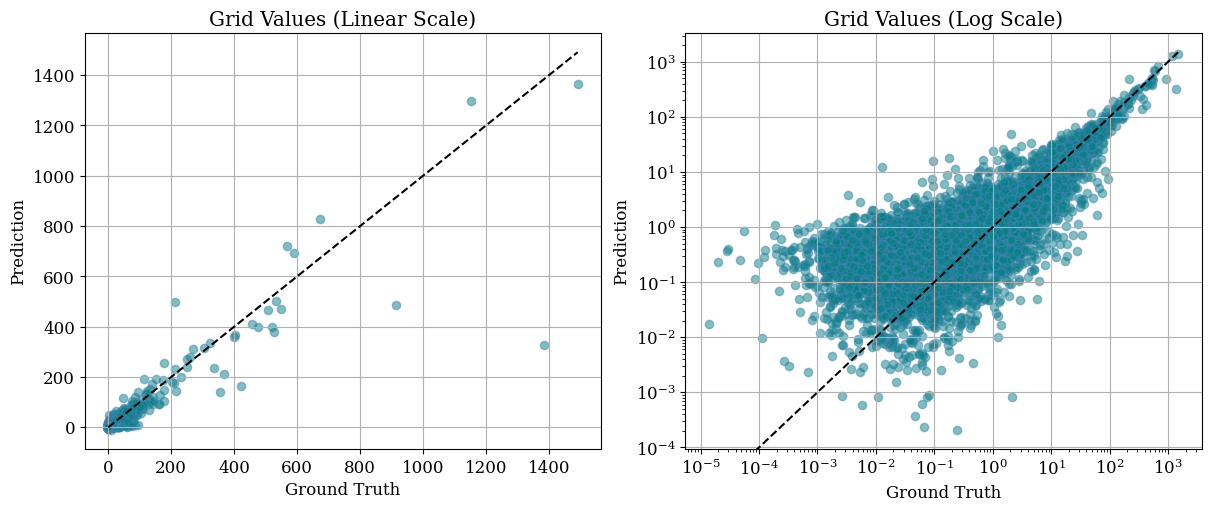

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5), constrained_layout=True)

ax1.set_title('Grid Values (Linear Scale)')
scatter_plot(ax1, GTs, PDs, scale='linear')

ax2.set_title('Grid Values (Log Scale)')
scatter_plot(ax2, GTs, PDs, scale='log')

plt.show()

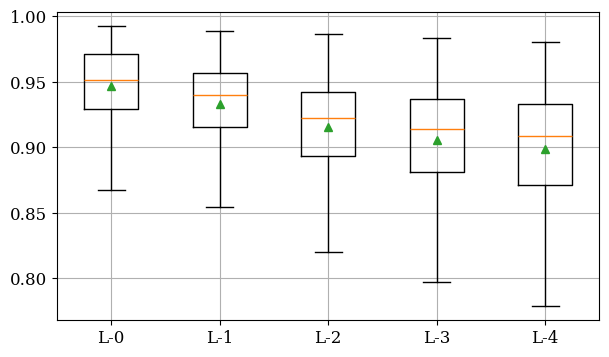

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))

l0 = r_squared_temporal(GTs, PDs, 0)['r_squared'].values
l1 = r_squared_temporal(GTs, PDs, 1)['r_squared'].values
l2 = r_squared_temporal(GTs, PDs, 2)['r_squared'].values
l3 = r_squared_temporal(GTs, PDs, 3)['r_squared'].values
l4 = r_squared_temporal(GTs, PDs, 4)['r_squared'].values

boxplot_data = [l0, l1, l2, l3, l4]

ax.boxplot([l0, l1, l2, l3, l4], showmeans=True, showfliers=False)
ax.set_xticklabels(['L-0', 'L-1', 'L-2', 'L-3', 'L-4'])

ax.grid()
plt.show()

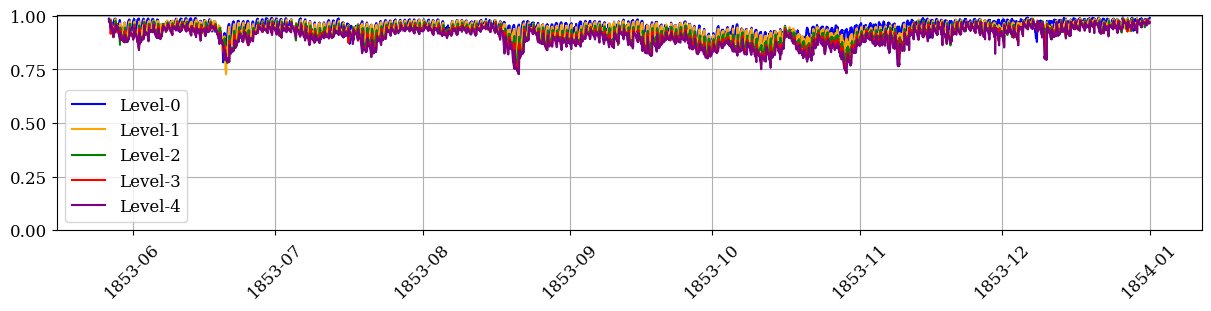

In [19]:
from matplotlib.ticker import MaxNLocator

fig, ax3 = plt.subplots(ncols=1, figsize=(12, 3), constrained_layout=True)

time = dataset.datetimeindex[:]


ax3.plot(time, l0, label='Level-0', color='blue')
ax3.plot(time, l1, label='Level-1', color='orange')
ax3.plot(time, l2, label='Level-2', color='green')
ax3.plot(time, l3, label='Level-3', color='red')
ax3.plot(time, l4, label='Level-4', color='purple')

ax3.tick_params(axis='x', labelrotation=45)
ax3.yaxis.set_major_locator(MaxNLocator(nbins=6)) 
ax3.set_yticks([0, 0.25, 0.5, 0.75, 1])  # Set y-axis ticks
ax3.grid()


plt.legend()
plt.show()

In [11]:
# Define the r_squared_spatial function
def r_squared_spatial(real_data, model_output):
    # Calculate the coefficient of determination (R^2)
    ss_res = np.sum((real_data - model_output) ** 2, axis=0)
    ss_tot = np.sum((real_data - np.mean(real_data, axis=0)) ** 2, axis=0)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [12]:
sr2 = r_squared_spatial(GTs, PDs)
sr2.shape

(5, 90, 144)

In [13]:
ds = xr.Dataset({
    'Real Data': (["time", "level", "lat", "lon"], GTs),
    'Model Output': (["time", "level", "lat", "lon"], PDs),
    'Coefficient of Determination': (["level", "lat", "lon"], sr2),

              },
              
     coords=dict(
        time = dataset.datetimeindex,
        level = np.arange(dataset.levels),
        lon  = dataset.lon,
        lat  = dataset.lat,
    )
)
ds

<xarray.Dataset> Size: 5GB
Dimensions:                       (time: 10512, level: 5, lat: 90, lon: 144)
Coordinates:
  * time                          (time) datetime64[ns] 84kB 1853-05-27T00:15...
  * level                         (level) int64 40B 0 1 2 3 4
  * lon                           (lon) float32 576B -178.8 -176.2 ... 178.8
  * lat                           (lat) float32 360B -90.0 -87.0 ... 87.0 90.0
Data variables:
    Real Data                     (time, level, lat, lon) float32 3GB 4.465e-...
    Model Output                  (time, level, lat, lon) float32 3GB 6.127e-...
    Coefficient of Determination  (level, lat, lon) float32 259kB -0.08121 .....

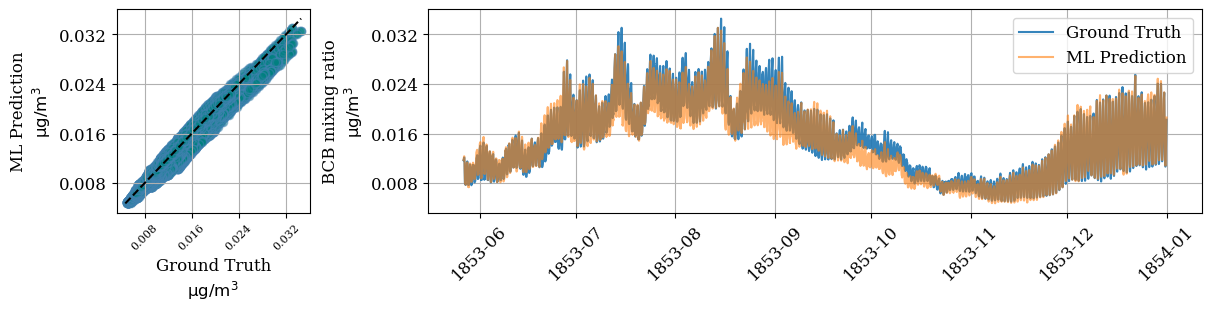

In [33]:
level = 0

fig, (ax1, ax3) = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})

weights = np.cos(np.deg2rad(ds.lat))
weights.name = "weights"

ds_avg = ds.weighted(weights).mean(dim=("lat", "lon"))

avgGT = ds_avg['Real Data'].isel(level=level).values
avgPD = ds_avg['Model Output'].isel(level=level).values

max_value = np.array((avgGT, avgPD)).max()
min_value = np.array((avgGT, avgPD)).min()

ax1.scatter(avgGT.ravel(), avgPD.ravel(), color='teal', edgecolor='steelblue', alpha=0.5)
ax1.plot([min_value, max_value], [min_value, max_value], '--', color='black', linewidth=1.5)

ax1.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5)) 
ax1.xaxis.set_major_locator(mticker.MaxNLocator(nbins=5)) 

ax1.tick_params(axis='x', labelrotation=45, labelsize=8)

# BCB mixing ratio
ax1.set_xlabel(r'Ground Truth' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=12)
ax1.set_ylabel(r'ML Prediction' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=12)

# ax1.text(-0.05, 1.15, '(a)', transform=ax1.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax1.grid()

ax3.plot(dataset.datetimeindex, avgGT, alpha=0.9, label='Ground Truth')
ax3.plot(dataset.datetimeindex, avgPD, alpha=0.6, label='ML Prediction')

ax3.yaxis.set_major_locator(MaxNLocator(nbins=5)) 
ax3.set_ylabel(r'BCB mixing ratio' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=12)
ax3.tick_params(axis='x', labelrotation=45)

# ax3.text(-0.05, 1.15, '(b)', transform=ax3.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
ax3.grid()

plt.legend()

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, '02-global_average.png'))

plt.show()

### Exceedence Probability

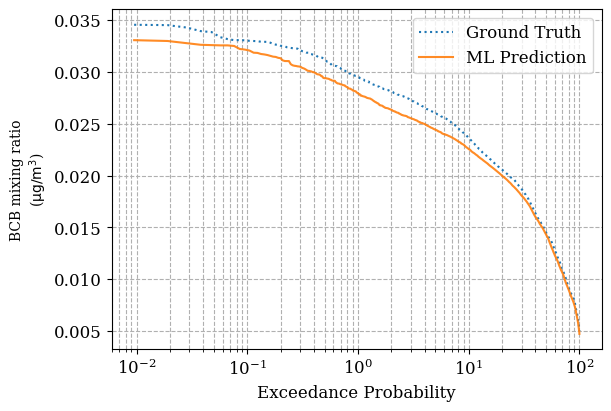

In [34]:
def exceedence_probability(values):
    v = np.array(values)  # Convert to numpy array
    v = -np.sort(-v)  # Sort in descending order
    ep = 100 * np.arange(1, len(v) + 1) / (len(v) + 1)  # Weibull formula
    return v, ep

v1, ep1 = exceedence_probability(avgGT)
v2, ep2 = exceedence_probability(avgPD)

# In case interpolation is needed
# np.interp(0.05, weibull_exceedance_probability, sorted_flow)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

# Plot the exceedance probabilities
ax.plot(ep1, v1, ':', alpha=1.0, label='Ground Truth')
ax.plot(ep2, v2, '-', alpha=0.9, label='ML Prediction')

# Set x-axis to logarithmic scale
ax.set_xscale('log')

# Add labels and title
ax.set_ylabel(r'BCB mixing ratio' '\n' r'($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', fontsize=10)
ax.set_xlabel('Exceedance Probability')

# Add grid, legend, and show the plot
ax.grid(True, which="both", ls="--")
ax.legend()

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, '04-exceedance_probabilities.png'))

plt.show()

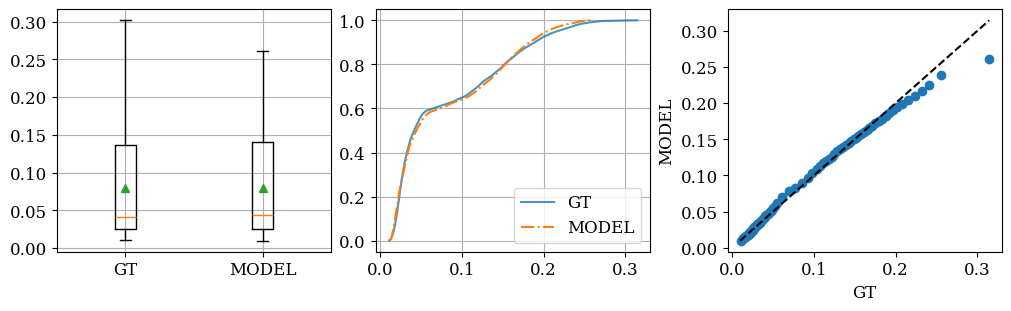

In [22]:
qqplot(avgGT.ravel(), avgPD.ravel(), yax1='' ,axis_names=None, quantiles=100, save_figure=False, fformat=None, saving_path=None)

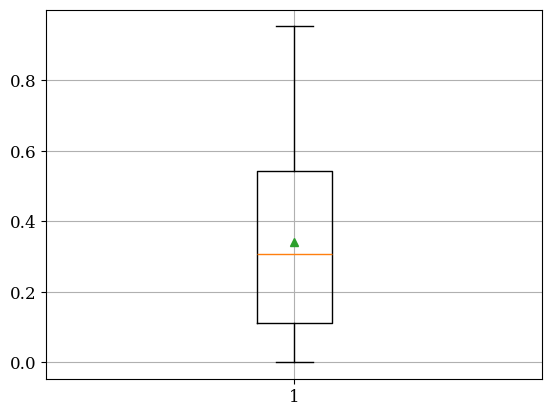

In [131]:
data = data[data > 0]
plt.boxplot(data, showmeans=True, showfliers=False)
plt.grid()
plt.show()


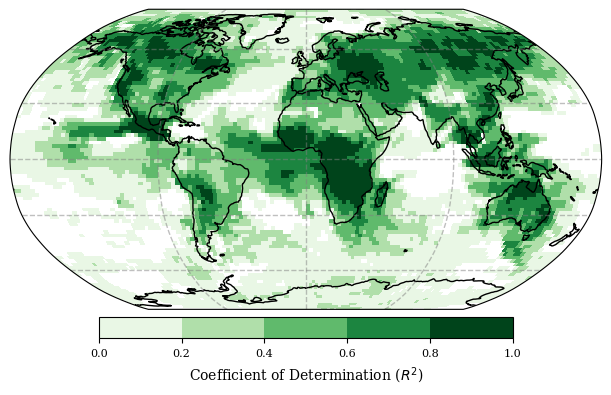

In [40]:
level=4
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)
import matplotlib.colors as mcolors
import matplotlib.ticker as mticker

ax.coastlines()

# Get the data for the current level
data = ds['Coefficient of Determination'].isel(level=level).values
data = np.where(data < 0, np.nan, data)  # Set negative values to zero

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Define stepwise colors and corresponding boundaries
colors = plt.cm.Greens(np.linspace(0.1, 1, 5))  # Adjust colors as needed
bounds = np.linspace(0, 1, 6)  # Define boundaries

# Create a colormap and normalization
cmap = mcolors.ListedColormap(colors)
cmap.set_bad((0.5, 0.5, 0.5, 0))  # RGBA Tuple
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the data using pcolormesh, which works better with projections
im = ax.pcolormesh(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    cmap=cmap, norm=norm,
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
# gl.top_labels = False

gl.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
# gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])

# # Add an individual colorbar for each subplot
cbar = plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.7)
cbar.set_label(r'Coefficient of Determination ($R^2$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, '03-r2_spatial_test.png'))

plt.show()

In [19]:
df = ds.to_dataframe(dim_order=['lat', 'lon', 'time']).reset_index()
gdf = df.groupby(['lat', 'lon'])
df.head()

,lat,lon,time,Real Data,Model Output,Coefficient of Determination
0,-90.0,-178.75,1951-01-01 23:45:00,0.000124,0.018657,-27.947145
1,-90.0,-178.75,1951-01-02 00:15:00,0.000123,0.015444,-27.947145
2,-90.0,-178.75,1951-01-02 00:45:00,0.000121,0.000932,-27.947145
3,-90.0,-178.75,1951-01-02 01:15:00,0.000120,0.000339,-27.947145
4,-90.0,-178.75,1951-01-02 01:45:00,0.000119,0.000310,-27.947145


In [18]:
def plot_on_grid(gdf, lat, lon, fig_num):

    from matplotlib import rcParams
    from matplotlib.ticker import MaxNLocator
    import matplotlib.ticker as ticker

    rcParams['font.size'] = 10  # Set the default font size

    g = gdf.get_group((lat, lon))
    g = g.sort_values('time')

    r2 = g['Coefficient of Determination'].iloc[0]
    print(f'exact coordinates, lat:{lat}, lon:{lon}, R2H: {r2:.2f}')
    

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})
    
    y_pred = g['Model Output']
    y_true = g['Real Data']

    corr, _ = pearsonr(y_true, y_pred)
    nse = r2_score(y_true, y_pred)

    ax1.text(0.1, 0.80, rf'r = {corr:.2f}', transform=ax1.transAxes, fontsize=8, va='top', ha='left')
    ax1.text(0.1, 0.70, rf'$R^2$ = {nse:.2f}', transform=ax1.transAxes, fontsize=8, va='top', ha='left')

    max_value = np.array((y_true, y_pred)).max()
    min_value = np.array((y_true, y_pred)).min()

    ax1.scatter(y_true, y_pred, color='teal', edgecolor='steelblue', alpha=0.5)
    ax1.plot([min_value, max_value], [min_value, max_value], '--', color='black', linewidth=1.5)

    ax1.set_xlabel(r'Ground Truth' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=8)
    # ax1.set_ylabel(r'ML Prediction' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=12)

    # Set the y-axis to scientific notation
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))

    ax1.yaxis.set_major_formatter(formatter)
    ax1.xaxis.set_major_formatter(formatter)
    ax1.xaxis.get_offset_text().set_visible(False)

    ax1.grid()


    # Rename columns directly in the plot command
    ax2.plot(g['time'], g['Real Data'], label='Ground Truth', alpha=1.0)
    ax2.plot(g['time'], g['Model Output'], label='ML Prediction', alpha=0.6)
    
    # Set x-ticks to display month names
    ax2.set_xlabel('', fontsize=8)
    ax2.tick_params(axis='x', labelrotation=0, labelsize=8)

    # ax2.set_ylabel(r'BCB mixing ratio' '\n' r'($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', fontsize=12)

    ax2.yaxis.set_major_formatter(formatter)
    # ax2.yaxis.get_offset_text().set_visible(False)
    # ax2.yaxis.set_label_text('Value (x $10^3$)')
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=5))

    # ax2.text(-0.05, 1.10, f'({fig_num})', transform=ax.transAxes, fontsize=12, fontweight='bold', va='top', ha='right')
    
    # Adjust the font size of the legend
    ax2.legend(fontsize=8, loc=2)  # Set the desired font size for the legend

    ax2.grid(True)

    # plt.savefig(f'fig05-{fig_num}.svg')
    plt.show()

In [19]:
def plot_on_map(lat, lon):

    fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

    ax1.coastlines()

    # Get the data for the current level
    data1 = ds['Real Data'].mean(dim='time').values

    # Define stepwise colors and corresponding boundaries
    colors = plt.cm.Oranges(np.linspace(0, 1, 10))  # Adjust colors as needed
    colors[0] = [1, 1, 1, 1]  # Set the first color to white
    bounds = np.linspace(0, .1, 11)  # Define boundaries
    bounds = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5]

    # Create a colormap and normalization
    cmap = mcolors.ListedColormap(colors)
    norm = mcolors.BoundaryNorm(bounds, cmap.N)

    # Create a meshgrid for longitude and latitude
    _lon, _lat = np.meshgrid(ds['lon'], ds['lat'])

    im1 = ax1.contourf(
        _lon, _lat, data1,
        transform=ccrs.PlateCarree(),
        levels=bounds, 
        cmap=cmap, norm=norm, extend='max'
    )

    plt.text(lon, lat, '.', color='magenta', fontsize=20, ha='center', va='center', transform=ccrs.PlateCarree())

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl1.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
    gl1.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

    gl1.xlabel_style = {'size': 8}  # Adjust the font size for x-axis labels
    gl1.ylabel_style = {'size': 8} 

    gl1.top_labels = False

    # Add an individual colorbar for each subplot
    cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.8, extend='max')
    cbar.set_label('Real Data' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=10)
    cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
    cbar.set_ticks(bounds)  # Explicitly set the ticks

    plt.show()

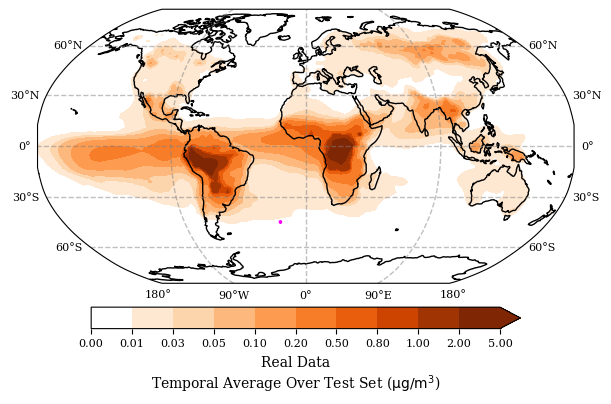

exact coordinates, lat:-41.0, lon:-18.75, R2H: -0.10


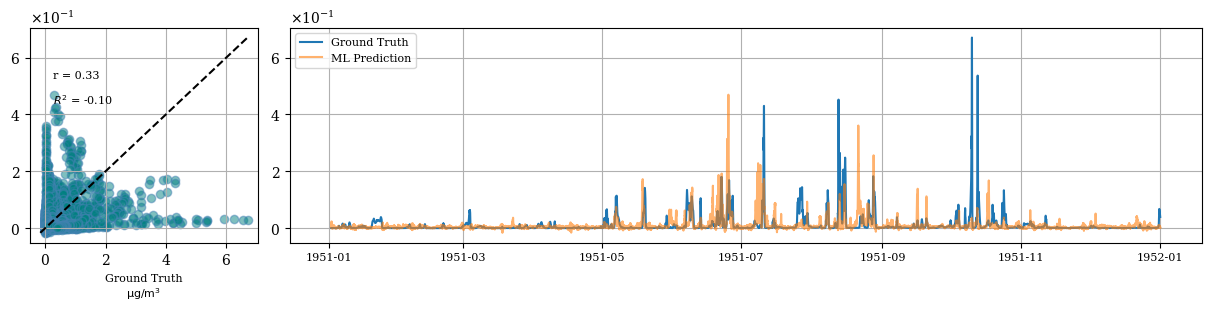

In [20]:
lat, lon = find_nearest(df[['lat', 'lon']], -40, -18)
plot_on_map(lat, lon)
plot_on_grid(gdf, lat, lon, 'b')

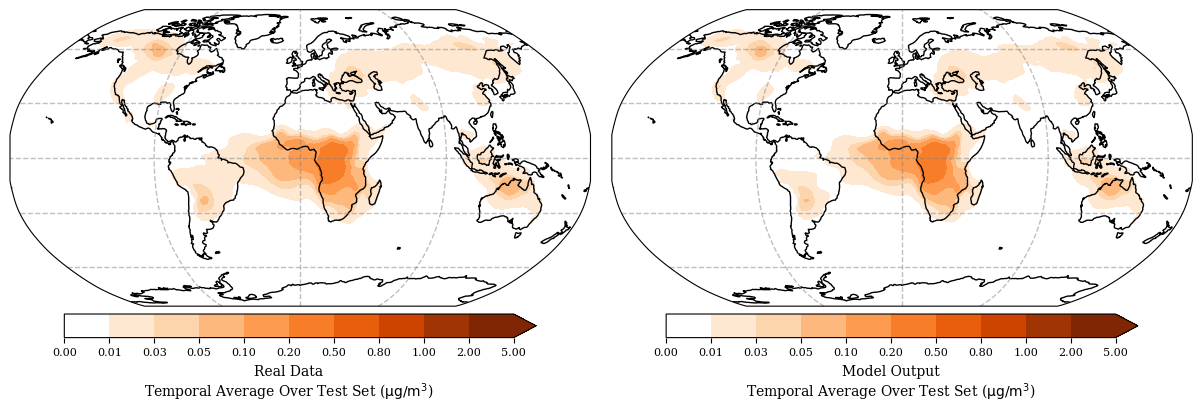

In [47]:
level = 4
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

ax1.coastlines()

# Get the data for the current level
data1 = ds['Real Data'].mean(dim='time').isel(level=level).values

# Define stepwise colors and corresponding boundaries
colors = plt.cm.Oranges(np.linspace(0, 1, 10))  # Adjust colors as needed
colors[0] = [1, 1, 1, 1]  # Set the first color to white
bounds = np.linspace(0, .1, 11)  # Define boundaries
# bounds[1] = 0.01
bounds = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5]

# Create a colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
# im1 = ax1.pcolormesh(
#     lon, lat, data1,
#     transform=ccrs.PlateCarree(),
#     # cmap='gist_heat_r',
#     cmap=cmap, norm=norm,
# )

im1 = ax1.contourf(
    lon, lat, data1,
    transform=ccrs.PlateCarree(),
    levels=bounds, 
    cmap=cmap, norm=norm, extend='max'
)


gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl1.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

gl1.xlabel_style = {'size': 8}  # Adjust the font size for x-axis labels
gl1.ylabel_style = {'size': 8} 

gl1.top_labels = False
# gl1.bottom_labels = False
# gl1.left_labels = False
# gl1.right_labels = False


# Add an individual colorbar for each subplot
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.8, extend='max')
cbar.set_label('Real Data' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
cbar.set_ticks(bounds)  # Explicitly set the ticks

ax2.coastlines()

# Get the data for the current level
data2 = ds['Model Output'].mean(dim='time').isel(level=level).values

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
# im2 = ax2.pcolormesh(
#     lon, lat, data2,
#     transform=ccrs.PlateCarree(),
#     cmap=cmap, norm=norm,
# )

im2 = ax2.contourf(
    lon, lat, data2,
    transform=ccrs.PlateCarree(),
    levels=bounds, 
    cmap=cmap, norm=norm, extend='max'
)

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl2.xlocator = mticker.FixedLocator([-180, -90, 0, 90, 180])
gl2.ylocator = mticker.FixedLocator([-60, -30, 0, 30, 60])

gl2.xlabel_style = {'size': 8}  # Adjust the font size for x-axis labels
gl2.ylabel_style = {'size': 8} 

gl2.top_labels = False
# gl2.bottom_labels = False
# gl2.left_labels = False
# gl2.right_labels = False

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im2, ax=ax2, orientation='horizontal', pad=0.02, shrink=0.8, extend='max')
cbar.set_label('Model Output' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
cbar.set_ticks(bounds)  # Explicitly set the ticks

# # Create separate patches for each set of axes
# tropical_zone1 = patches.Rectangle((-180, -21), 360, 42, linewidth=1, edgecolor='green', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
# tropical_zone2 = patches.Rectangle((-180, -21), 360, 42, linewidth=1, edgecolor='green', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())

# ax1.add_patch(tropical_zone1)
# ax2.add_patch(tropical_zone2)

# northern_mid_latitude_zone = patches.Rectangle((-180, 21), 360, 40, linewidth=1, edgecolor='blue', facecolor='none', linestyle='--', zorder=2, transform=ccrs.PlateCarree())
# ax1.add_patch(northern_mid_latitude_zone)

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, '05-annual_average.png'))

plt.show()

The quantile of the value 0.01 (μg/m^3) is 66.23%


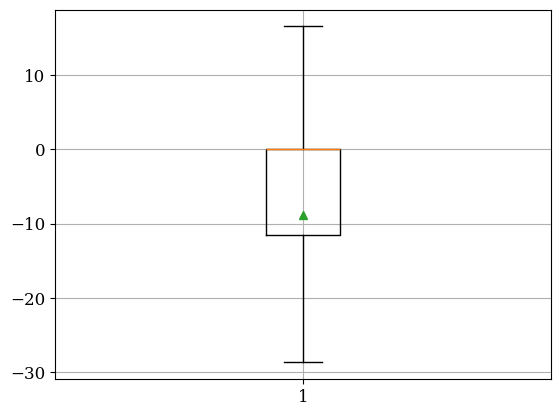

In [142]:
from scipy.stats import percentileofscore

threshold = 1E-2

# Get the data for the current level
data1 = ds['Real Data'].mean(dim='time').values
data2 = ds['Model Output'].mean(dim='time').values
data = np.where(data1 < threshold, 0, ((data2-data1)/data1) * 100)  # Set negative values to zero

# Calculate the quantile (percentile) of the given value
quantile = percentileofscore(data1.flatten(), threshold) / 100.0

print(f"The quantile of the value {threshold} (μg/m^3) is {quantile:.2%}")

plt.boxplot(data.flatten(), showmeans=True, showfliers=False)
plt.grid()
plt.show()

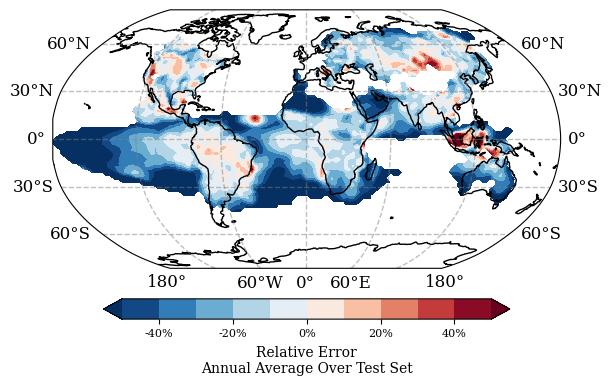

In [22]:
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)


ax1.coastlines()

# Get the data for the current level
data1 = ds['Real Data'].mean(dim='time').values
data2 = ds['Model Output'].mean(dim='time').values

data = np.where(data1 < 1E-2, np.nan, (data2-data1)/data1)  # Set negative values to zero



# Generate a sequence of values between 0 and 1
values = np.linspace(0, 1, 6)

# Sample colors from the Reds and Blues colormaps
reds = plt.cm.Reds(values)
blues = plt.cm.Blues_r(values)

# Define the middle gray color
gray = np.array([[1.0, 1.0, 1.0, 1.0]])  # RGBA for gray

# Combine the colors into a single array
colors = np.vstack((blues[:-1], reds[1:]))
bounds = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]


# Create a colormap and normalization
cmap = mcolors.ListedColormap(colors)
cmap.set_bad((0.5, 0.5, 0.5, 1))  # RGBA Tuple
norm = mcolors.BoundaryNorm(bounds, cmap.N)


# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

# Plot the data using pcolormesh, which works better with projections
# im1 = ax1.pcolormesh(
#     lon, lat, data,
#     transform=ccrs.PlateCarree(),
#     cmap=cmap, norm=norm,

# )

im1 = ax1.contourf(
    lon, lat, data,
    transform=ccrs.PlateCarree(),
    levels=bounds, 
    cmap='RdBu_r', extend='both'
)

# ax1.add_feature(cfeature.LAND, color='gray')
# ax1.add_feature(cfeature.OCEAN, color='lightblue')
# ax1.add_feature(cfeature.COASTLINE, edgecolor='black')
# ax1.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black')


gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.8)
cbar.set_label('Relative Error' '\n' r'Annual Average Over Test Set', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
# cbar.set_ticks(bounds)  # Explicitly set the ticks

# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True)
# formatter.set_powerlimits((-3, 3))

# Format the colorbar labels as percentages
# cbar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(formatter))
cbar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x:.0%}'))

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, '06-relative_error.png'))

plt.show()



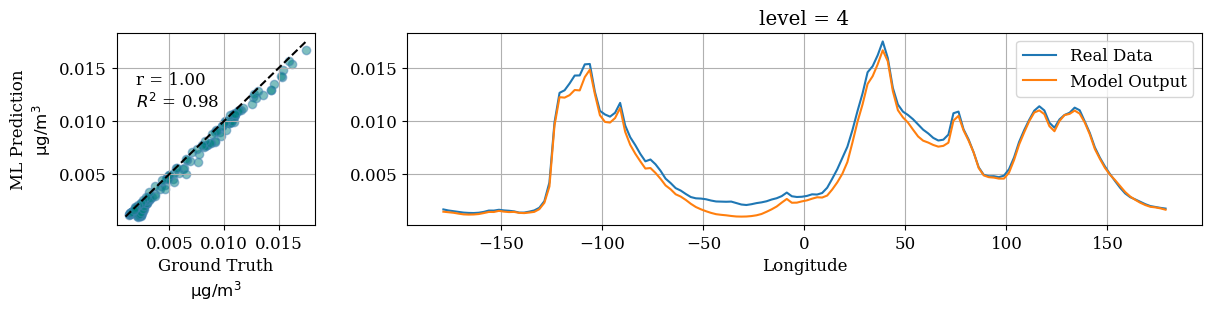

In [53]:
level = 4

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), constrained_layout=True, gridspec_kw={'width_ratios':[1, 4]})

roi = 'Northern Mid-Latitude Zone'
# roi = 'Tropical Zone'

if roi == 'Northern Mid-Latitude Zone':
    ds_roi = ds.sel(lat=slice(21, 61)).isel(level=level).mean(dim=("time"))

elif roi == 'Tropical Zone':
    ds_roi = ds.sel(lat=slice(-21, 21)).isel(level=level).mean(dim=("time"))

weights = np.cos(np.deg2rad(ds_roi.lat))
weights.name = "weights"

avgGT = ds_roi['Real Data'].weighted(weights).mean(dim=("lat"))
avgPD = ds_roi['Model Output'].weighted(weights).mean(dim=("lat"))

corr, _ = pearsonr(avgGT.values, avgPD.values)
nse = r2_score(avgGT.values, avgPD.values)

ax1.text(0.1, 0.80, rf'r = {corr:.2f}', transform=ax1.transAxes, fontsize=12, va='top', ha='left')
ax1.text(0.1, 0.70, rf'$R^2$ = {nse:.2f}', transform=ax1.transAxes, fontsize=12, va='top', ha='left')

max_value = np.array((avgGT, avgPD)).max()
min_value = np.array((avgGT, avgPD)).min()

ax1.scatter(avgGT.values, avgPD.values, color='teal', edgecolor='steelblue', alpha=0.5)
ax1.plot([min_value, max_value], [min_value, max_value], '--', color='black', linewidth=1.5)

ax1.set_xlabel(r'Ground Truth' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=12)
ax1.set_ylabel(r'ML Prediction' '\n' r'$\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$', fontsize=12)

ax1.grid()

avgGT.plot(ax=ax2, label='Real Data')
avgPD.plot(ax=ax2, label='Model Output')

ax2.set_xlabel('Longitude')
ax2.set_ylabel(' ')

ax2.legend()
ax2.grid()

if save_figure:
    plt.savefig(os.path.join(snapshot_dir, f'07-RegionalAnalysis_{roi}.png'))

plt.show()

In [9]:
# GFED (global fire emissions database) regions
gfed = {
    "BONA": [50, 70, -170, -50],
    "TENA": [25, 50, -170, -50],
    "CEAM": [0, 25, -120, -60],
    "NHSA": [-10, 0, -85, -35],
    "SHSA": [-55, -10, -85, -35],
    "EURO": [35, 70, -10, 60],
    "MIDE": [15, 45, 30, 70],
    "NHAF": [0, 15, -20, 50],
    "SHAF": [-35, -10, -20, 50],
    "BOAS": [50, 70, 60, 180],
    "CEAS": [30, 50, 60, 120],
    "SEAS": [15, 25, 75, 115],
    "EQAS": [-10, 10, 95, 150],
    "AUST": [-50, -10, 110, 180],
}
gfed_ds = xr.open_dataset('basis_regions_regridded.nc')

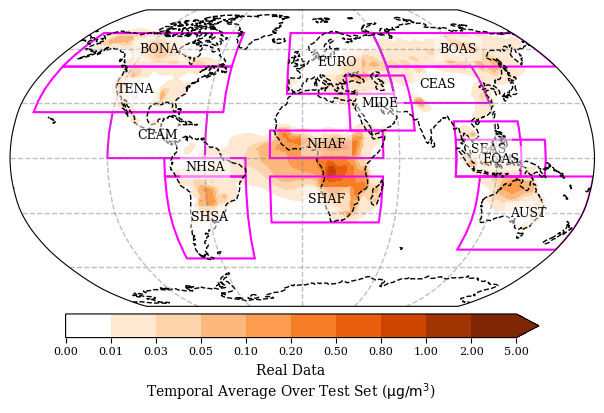

In [27]:
level = 0

fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

ax1.set_global()

# Get the data for the current level
data1 = ds['Real Data'].isel(level=level).mean(dim='time').values

# Define stepwise colors and corresponding boundaries
colors = plt.cm.Oranges(np.linspace(0, 1, 10))  # Adjust colors as needed
colors[0] = [1, 1, 1, 1]  # Set the first color to white
bounds = np.linspace(0, .1, 11)  # Define boundaries
bounds = [0, 0.01, 0.03, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 2, 5]

# Create a colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Create a meshgrid for longitude and latitude
lon, lat = np.meshgrid(ds['lon'], ds['lat'])

im1 = ax1.contourf(
    lon, lat, data1,
    transform=ccrs.PlateCarree(),
    levels=bounds, 
    cmap=cmap, norm=norm, extend='max'
)

ax1.add_feature(cfeature.COASTLINE, linestyle='--')
gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, color='gray', alpha=0.5, linestyle='--')

# Add boxes and labels
for i, (name, (lat_min, lat_max, lon_min, lon_max)) in enumerate(gfed.items(), 1):
    rect = patches.Rectangle(
        (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
        linewidth=1.5, edgecolor='magenta', facecolor='none', transform=ccrs.PlateCarree()
    )
    ax1.add_patch(rect)
    ax1.text(
        (lon_min + lon_max) / 2, (lat_min + lat_max) / 2, f"{name}",
        transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=9,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )

# Add an individual colorbar for each subplot
cbar = plt.colorbar(im1, ax=ax1, orientation='horizontal', pad=0.02, shrink=0.8, extend='max')
cbar.set_label('Real Data' '\n' r'Temporal Average Over Test Set ($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', rotation=0, labelpad=5, fontsize=10)
cbar.ax.tick_params(labelsize=8)  # Adjust the font size here
cbar.set_ticks(bounds)  # Explicitly set the ticks

plt.show()

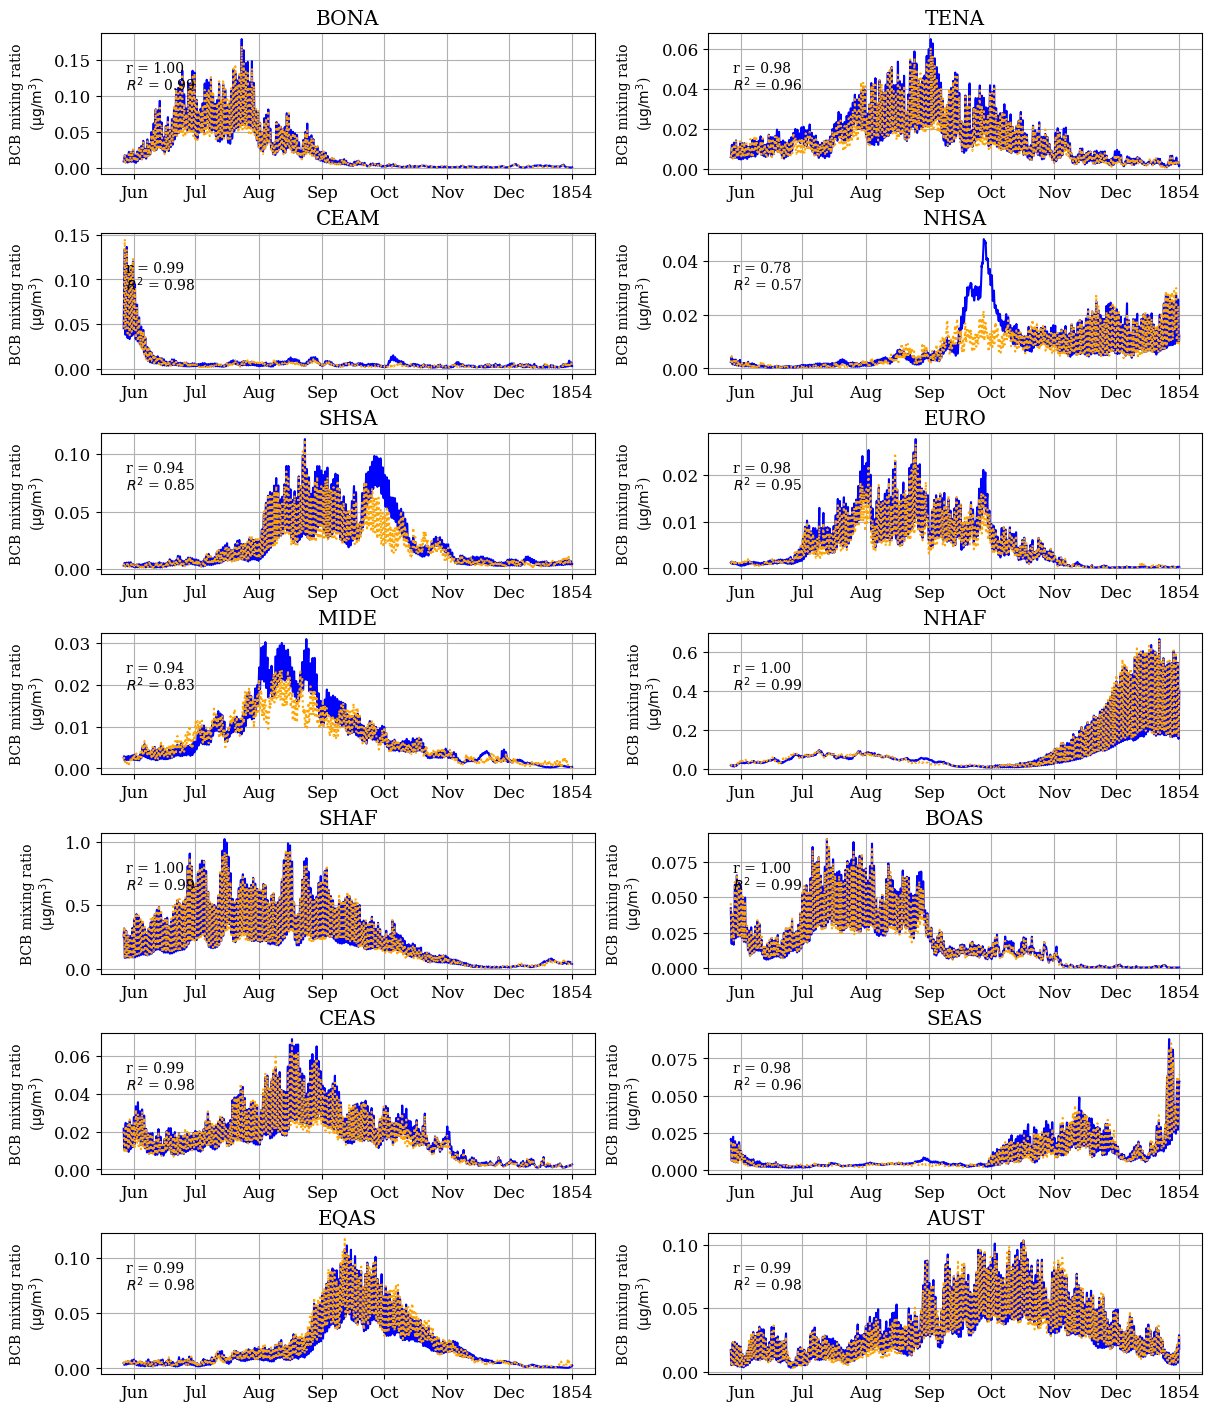

In [14]:
level = 0

fig, axs = plt.subplots(nrows=7, ncols=2, figsize=(12, 14), constrained_layout=True)
axs = axs.flatten()

for i, (name, (lat_min, lat_max, lon_min, lon_max)) in enumerate(gfed.items(), 1):

    weights = np.cos(np.deg2rad(ds.lat))
    weights.name = "weights"

    avgGT = ds['Real Data'].isel(level=level).where(gfed_ds['basis_regions'] == i).weighted(weights).mean(dim=("lat", "lon"))
    avgPD = ds['Model Output'].isel(level=level).where(gfed_ds['basis_regions'] == i).weighted(weights).mean(dim=("lat", "lon"))

    corr, _ = pearsonr(avgGT.values, avgPD.values)
    nse = r2_score(avgGT.values, avgPD.values)

    axs[i-1].text(0.05, 0.80, rf'r = {corr:.2f}', transform=axs[i-1].transAxes, fontsize=10, va='top', ha='left')
    axs[i-1].text(0.05, 0.70, rf'$R^2$ = {nse:.2f}', transform=axs[i-1].transAxes, fontsize=10, va='top', ha='left')

    # Plot the data

    avgGT.plot(ax=axs[i-1], label='Real Data', color='blue')
    avgPD.plot(ax=axs[i-1], label='Model Output', color='orange', linestyle=':')

    axs[i-1].set_xlabel('', fontsize=10)
    axs[i-1].set_ylabel(r'BCB mixing ratio' '\n' r'($\mathrm{\mu g} / \mathrm{m}^{\mathrm{3}}$)', fontsize=10)

    axs[i-1].set_title(name)
    # axs[i-1].legend(fontsize=10)

    axs[i-1].grid()

plt.show()

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# Read basis_regions from HDF5
with h5py.File('GFED4.1s_2000.hdf5', 'r') as file:
    basis_regions = file['ancill']['basis_regions'][:]
    lats = -file['lat'][:][:, 0]
    lons = file['lon'][:][0, :]

# Flip vertically for geographic orientation
basis_regions_flipped = np.flipud(basis_regions)

# Create xarray Dataset
ds_basis = xr.DataArray(
    basis_regions_flipped,
    dims=("lat", "lon"),
    coords={"lat": lats, "lon": lons},
    name="basis_regions"
).to_dataset()

# Save to NetCDF
ds_basis.to_netcdf("basis_regions.nc")

# --- Regridding ---
basis_regions_regridded = ds_basis.interp(
    lat=ds.lat,
    lon=ds.lon,
    method="nearest"
)

# Save to NetCDF
basis_regions_regridded.to_netcdf("basis_regions_regridded.nc")

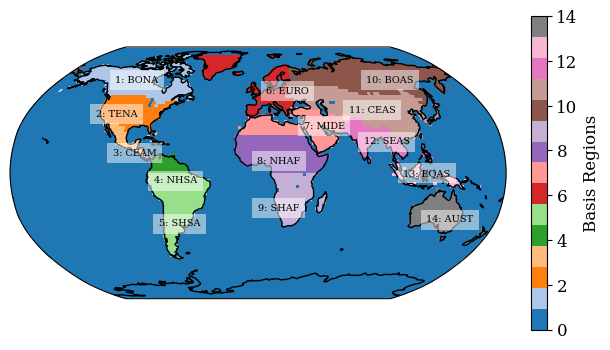

In [28]:
# Create a 15-color colormap from tab20
from matplotlib.colors import ListedColormap
cmap15 = ListedColormap(plt.get_cmap('tab20').colors[:15])

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 4), subplot_kw={'projection': ccrs.Robinson()}, constrained_layout=True)

ax.set_global()
ax.coastlines() 

gfed_ds['basis_regions'].plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    cmap=cmap15,
    add_colorbar=True,
    cbar_kwargs={'label': 'Basis Regions', 'shrink': 0.8}
)


for i, (name, (lat_min, lat_max, lon_min, lon_max)) in enumerate(gfed.items(), 1):
    rect = patches.Rectangle(
        (lon_min, lat_min), lon_max - lon_min, lat_max - lat_min,
        linewidth=1.5, edgecolor='magenta', facecolor='none', transform=ccrs.PlateCarree()
    )
    # ax.add_patch(rect)
    ax.text(
        (lon_min + lon_max) / 2, (lat_min + lat_max) / 2, f"{i}: {name}",
        transform=ccrs.PlateCarree(), ha='center', va='center', fontsize=7,
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none')
    )


plt.show()